A while ago I ditched MATLAB as my main development environment for my research projects. Since then I have been playing around with [Python](https://www.python.org/) and [Julia](http://julialang.org) to find a suitable replacement. 
Although Python is extremely pleasant to use, I find myself these days mostly using Julia for my research and occasionally accessing Python libraries through [PyCall](https://github.com/stevengj/PyCall.jl).
I suppose the reason for this is that my requirements match (or at least overlap to a great extent) the requirements that the creators of Julia had in mind when designing the language.
The language feels both expressive and fast. Even mundane tasks, such as data pre-processing are quickly written, yet execute often noticeably faster than in Python.

Another compelling reason for adopting Julia now is that the current release (v0.4.5 at the time of writing) feels quite mature and usable, especially since precompiled packages were introduced.
There tons of other interesting features, most notably simple parallel processing support right in the standard library. This, together with the easily deployable binary distribution, makes it very easy to setup a poor man's cluster.

I recently talked about my experiences with Julia in my Lab's group meeting where the following demo was part of show-casing the language's capabilities.

### The Task: Computing Hidden States of a Recurrent Neural Network

In many scientific computing applications, we can often get good performance out of interpreted languages, such as Python, R, or MATLAB, by expressing the most expensive computations in terms of matrix operations that are then outsourced to highly optimized library routines.
However, this is not always possible or requires some `repmat` and `reshape` acrobatics where a simple loop would have been a better and more readable choice.

One such example is the computation underlying recurrent neural networks (RNNs).
RNNs are being successfully used to capture the latent dynamics that govern the generation of complex sequential data, such as natural language. See this [blog post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) for an excellent introduction. We use the same setup in that we would like to map a sequence $x = [x_t]_{t=1,\ldots,T}$ with elements
$x_t \in \{1,\ldots,M\}$ of $T$ discrete inputs from a fixed dictionary to a sequence of $T$ real-valued vectors $h_t \in \mathbb{R}^D$. These vectors can then be used e.g. to compute a distribution over the possible values of $x_{T+1}$. 

The forward equations of a vanilla RNN hidden vectors are:
1. Compute activation:   $a_t = W_h h_{t-1} + W_i(x_t)$
2. Apply point-wise non-linearity: $h_t = \sigma(a_t)$

Note that step 1 depends on the result at the previous time step. As inputs we require an initial vector $h_0$ and a sequence $x$. The model is parameterized by matrices $W_h \in \mathbb{R}^{D\times D}$, and $W_i \in \mathbb{R}^{D \times M}$.

We implement this in C++, Julia, and Python and benchmark these implementations.

Note, that the complexity of this computation is $O(T D^2)$, and the choice of language won't change that.
What we are after is to quantify the constant factors that can make a big difference in practice.

### Python Implementation

The implementation in Python is straight-forward. We use numpy (linked with Intel MKL) to deal with matrix multiplication and measure the execution time within Python to exclude the overhead of PyCall (which is small).

```Python
from numpy import *
import time

def sigmoid(v):
    return 1.0 / (1.0 + exp(-v))

def step(xt, htm1, Wh, Wi):
    return sigmoid(dot(Wh, htm1) + Wi[xt,:])

def pyfwd(x,h0, Wh, Wi):
    ht = h0
    tic = time.time()
    for xt in x:
        ht = step(xt, ht, Wh,Wi)
    toc = time.time() - tic
    return ht, toc
```



### Julia Implementation

The implementation in Julia looks not much different.

In [1]:
include("setup.jl")
σ(v) = 1.0 ./ (1.0 + exp(-v))

function rnnstep(xt, htm1, Wh, Wi)
    return σ(Wh * htm1 + Wi[:,xt])
end

function jlfwd(x, h0, Wh, Wi)
    ht = h0
    tic()
    for xt in x
        ht = rnnstep(xt, ht, Wh, Wi)
    end
    toc = toq()
    return ht, toc
end;

### C++ Implementation

The C++ implementation uses the excellent [Armadillo](http://arma.sourceforge.net/) library.
For matrix multiplications (when using larger matrices) we configure Armadillo to link with an optimized BLAS implementation (in this case Intel MKL).

```C++
#include <iostream>
#include <armadillo>
#include <chrono>

using namespace std;
using namespace chrono;

/*
 * Inputs:
 * - px:  pointer to sequence array
 * - S:   length of sequence
 * - ph:  pointer to initial hidden state (will be overwritten)
 * - pWh: pointer to transition matrix
 * - pWi: pointer to input embedding
 * - D:   number of hidden neurons
 * - M:   number of items
 */
extern "C" double fwd(int64_t * px, 
                      int S, 
                      double * ph, 
                      double * pWh, 
                      double * pWi, 
                      int D, 
                      int M);

double fwd(int64_t * px, 
           int S, 
           double * ph, 
           double * pWh, 
           double * pWi,  
           int D, 
           int M){
    //wrap raw input pointers in Armadillo objects
    arma::Col<int64_t> x(px, S, false, false);
    arma::mat Wh(pWh, D, D, false, false);
    arma::mat Wi(pWi, D, M, false, false);
    arma::vec h(ph, D, false, false);

    //allocate vector of activations at time t
    arma::vec at(D);

    //tic...
    high_resolution_clock::time_point tic = high_resolution_clock::now();
    for(auto xt : x){
        at = Wh * h + Wi.col(xt);
        h = 1.0 / (1.0 + exp(-at));
    }
    //...toc
    high_resolution_clock::time_point toc = high_resolution_clock::now();

    auto duration = duration_cast<microseconds>( toc - tic  ).count();
    chrono::duration<double> fp_ms = toc - tic;
    return fp_ms.count();
}
```

We compile this using the flags `g++ --std=c++1 -O3` and build a shared object (using gcc version 4.8.4).
If the shared library (e.g. `libcppfwd.so`) is placed in a directory included in `LD_LIBRARY_PATH`, we can call `fwd` from Julia using `ccall`:
```Julia
ccall((:fwd,"libcppfwd"), 
      Cdouble, 
      ( Ptr{Int}, # signature
        Int32,
        Ptr{Cdouble},
        Ptr{Cdouble},
        Ptr{Cdouble},
        Int32,
        Int32 ), 
      x,      # sequence 
      S,      # sequence length
      h0,     # initial hidden state
      Wh, Wi, # RNN parameters
      D,      # hidden dimension
      M)      # output size
```

Note, that changes to the shared object typically require a restart of the Julia kernel to take effect.

### Measuring Running Time

In order to get an idea of the gain in efficiency due to the language, we use very small parameter matrices, such that differences in the BLAS implementation are negligible. 

We compute the forward pass for sequences of increasing length for a number of times and report the time of the fastest run.

In [2]:
import PyCall  #we call the Python version from within Julia
import mymod   #this module contains the ccall
pyfwd = PyCall.pyimport("mymod")["pyfwd"]

#Problem dimensions
M = 10
D = 5
logSlens = 3:16
Slens = 2 .^ (logSlens)

#Generate model parameters
Wh = randn(D,D)
Wipy = randn(M,D)
Wijl = Wipy' #Julia and C++ are column-major
h0 = randn(D)

#Generate input sequences
Xs = map(S -> rand(1:M, S), Slens)
nRuns = 3
tjl = zeros(length(Slens), nRuns)
tpy = zeros(length(Slens), nRuns)
tcpp = zeros(length(Slens), nRuns)
hcpp_i = copy(h0)
for (it, x) in enumerate(Xs)
    xpy = x - 1 #Python and C++ are 0-based!
    for jt in 1:nRuns
        hcpp_i[:] = h0
        hjl_i, tjl_i = jlfwd(x, h0, Wh, Wijl)
        tcpp_i = mymod.cppfwd!(xpy, hcpp_i, Wh, Wijl)
        hpy_i, tpy_i = pyfwd(xpy, h0, Wh, Wipy)
        tjl[it, jt] = tjl_i
        tpy[it, jt] = tpy_i
        tcpp[it,jt] = tcpp_i
        
        assert(vecnorm(hcpp_i - hjl_i) < 1e-12)
        assert(vecnorm(hcpp_i - hpy_i) < 1e-12)
        assert(vecnorm(hjl_i - hpy_i) < 1e-12)
    end
end
tpy, tjl, tcpp = minimum(tpy,2),minimum(tjl,2),minimum(tcpp,2);

### Results

Here, we plot the running time of the different versions. The speedup appears to be quite constant over all input sizes. The Julia code is about 15 times faster than Python, and C++ is about 2.5 times faster than Julia.

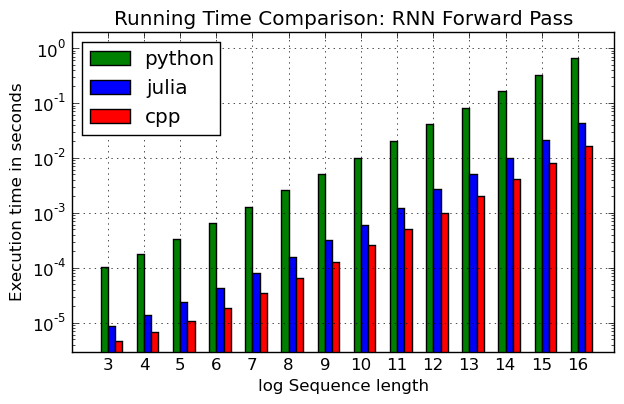

In [3]:
using PyPlot
ion()
figure(figsize=(7, 4))
left = 1:length(Slens)
bar(left-0.2,tpy, width=0.2, color="g");
bar(left,tjl, width=0.2);
bar(left+0.2,tcpp, width=0.2, color="r");
ax = gca()
ax["set_yscale"]("log")
ax["grid"]("on")
ax["set_xticks"](left)
ax["set_xticklabels"](logSlens)
xlabel("log Sequence length");
ylabel("Execution time in seconds");
legend(["python","julia","cpp"], loc=2)
title("Running Time Comparison: RNN Forward Pass")
xlim([0, 15])
ylim([3e-6,2]);

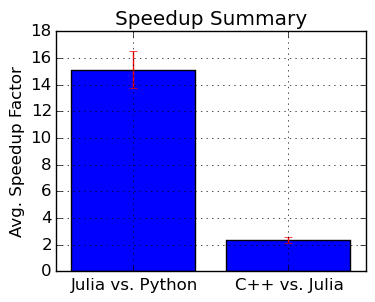

In [4]:
figure(figsize=(4,3))
title("Speedup Summary")
means = [mean(tpy./tjl),mean(tjl./tcpp)]
stds = [std(tpy./tjl),std(tjl./tcpp)]
bar([1,2]-0.4,means,width=0.8, yerr=stds, ecolor="red")
ax = gca()
ax["grid"]("on")
ax["set_xticks"]([1,2])
ax["set_xticklabels"](["Julia vs. Python", "C++ vs. Julia"])
ylabel("Avg. Speedup Factor");

### Conclusion

This example illustrates and quantify the benefits of using Julia.
Of course it is somewhat contrived and ignores important aspects such as the effect of memory management in more extreme scenarios.
Still, it gives a rough idea of the kind of speedup one can expect in many relevant scenarios where loops cannot be avoided.

Personally, I find Julia extremely pleasant to work with and the technology it is based on quite impressive and promising. I hope it will continue to do well.